In [1]:
%load_ext autoreload
%autoreload 2

# Use trained network to select the most fit circuits

## Imports

In [2]:
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols
from synbio_morpher.utils.data.data_format_tools.common import write_json
from synbio_morpher.utils.misc.string_handling import prettify_keys_for_label
from typing import List
from functools import partial

import os
import sys
import numpy as np
import haiku as hk
import jax
import jax.numpy as jnp
import equinox as eqx
import optax  # https://github.com/deepmind/optax

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.metrics import r2_score
                
import wandb

from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('talk')
sns.set_style("whitegrid")

jax.config.update('jax_platform_name', 'gpu')


module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

__package__ = os.path.basename(module_path)


jax.devices()

I0000 00:00:1698947105.256036 1229610 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


[gpu(id=0)]

In [3]:
from src.models.mlp import MLP, MLP_fn
from src.losses.losses import loss_fn, compute_accuracy_categorical, compute_accuracy_regression
from src.utils.math import custom_round, convert_to_scientific_exponent, arrayise
from src.utils.data_preprocessing import drop_duplicates_keep_first_n

# Load data and previously trained network

## Data

In [4]:
fn = '../data/processed/ensemble_mutation_effect_analysis/2023_07_17_105328/tabulated_mutation_info.csv'
fn_test_data = '../data/raw/ensemble_mutation_effect_analysis/2023_10_03_204819/tabulated_mutation_info.csv'
data = pd.read_csv(fn)
try:
    data.drop(columns=['Unnamed: 0'], inplace=True)
except:
    pass

## Model

### Hyperparameters used to create the model

In [5]:
BATCH_SIZE = 128
N_BATCHES = 1200
TOTAL_DS = BATCH_SIZE * N_BATCHES
MAX_TOTAL_DS = TOTAL_DS
train_split_perc = 0.8
TRAIN_SPLIT = int(train_split_perc * TOTAL_DS)
TEST_SPLIT = TOTAL_DS - TRAIN_SPLIT
EPOCHS = 1000
SEED = 1
INPUT_SPECIES = 'RNA_1'
target_circ_func = 'sensitivity_wrt_species-6'

# MLP Architecture
LAYER_SIZES = [64, 64, 64]
USE_CATEGORICAL = False
USE_DROPOUT = False
USE_L2_REG = False
USE_WARMUP = False

loss_fn = partial(
    loss_fn, loss_type='categorical' if USE_CATEGORICAL else 'mse', use_l2_reg=USE_L2_REG)
compute_accuracy = compute_accuracy_categorical if USE_CATEGORICAL else compute_accuracy_regression

rng = jax.random.PRNGKey(SEED)

In [6]:
vectorized_convert_to_scientific_exponent = np.vectorize(
    convert_to_scientific_exponent)
filt = data['sample_name'] == INPUT_SPECIES

# Balance the dataset
df = drop_duplicates_keep_first_n(data[filt], get_true_interaction_cols(
    data, 'energies', remove_symmetrical=True), n=100)
df[target_circ_func] = df[target_circ_func].round(
    np.abs(int(f'{df[target_circ_func].min():.0e}'.split('e')[1]))-1)
df = drop_duplicates_keep_first_n(
    df, column=target_circ_func, n=200)

TOTAL_DS = np.min([TOTAL_DS, MAX_TOTAL_DS, len(df)])
TOTAL_DS


116888

In [7]:
x = df[get_true_interaction_cols(data, 'energies', remove_symmetrical=True)].iloc[:TOTAL_DS].values
y = df[target_circ_func].iloc[:TOTAL_DS].to_numpy()

zero_log_replacement = -10.0
y = np.where(y != 0, np.log10(y), zero_log_replacement)

x, y = shuffle(x, y, random_state=SEED)

N_HEAD = 1

/tmp/ipykernel_814512/2380332271.py:5: RuntimeWarning: divide by zero encountered in log10
  y = np.where(y != 0, np.log10(y), zero_log_replacement)


In [8]:
xscaler, yscaler = MinMaxScaler(), MinMaxScaler()
x = xscaler.fit_transform(x)

### Recreate model

In [9]:
model = hk.transform(partial(MLP_fn, init_kwargs={
                     'layer_sizes': LAYER_SIZES, 'n_head': N_HEAD, 'use_categorical': USE_CATEGORICAL}))

params = model.init(rng, x[:2])

/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/haiku/_src/initializers.py:126: UserWarning: Explicitly requested dtype float64  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  unscaled = jax.random.truncated_normal(
/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/haiku/_src/base.py:682: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


### Saved weights

In [18]:
save_path = 'saves_best_2023_11_01__00_35_39'
# save_path = 'saves_small_ds1'
saves_loaded = load_json_as_dict(save_path)

step = list(saves_loaded.keys())[-1]
p = saves_loaded[str(step)]['params']
p = arrayise(p)

print([p[k]['w'].shape for k in p.keys()])

[(6, 64), (64, 64), (64, 64), (64, 1)]


In [19]:
y.shape

(116888,)

## Visualise

### Accuracy

<Axes: >

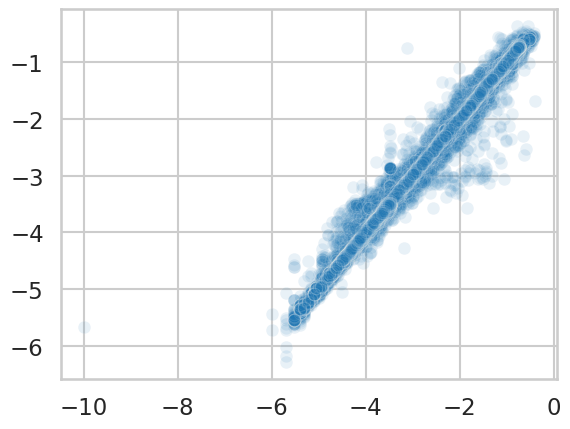

In [140]:
pred_y = model.apply(p, rng, x, call_kwargs={'inference': True, 'logging': False}).squeeze()
sns.scatterplot(x=y, y=pred_y, alpha=0.1)

In [21]:

data['predicted_' + target_circ_func] = np.power(
    10,
    model.apply(p, rng, xscaler.fit_transform(data[get_true_interaction_cols(
        data, 'energies', remove_symmetrical=True)].values), call_kwargs={'inference': True, 'logging': False})
    )

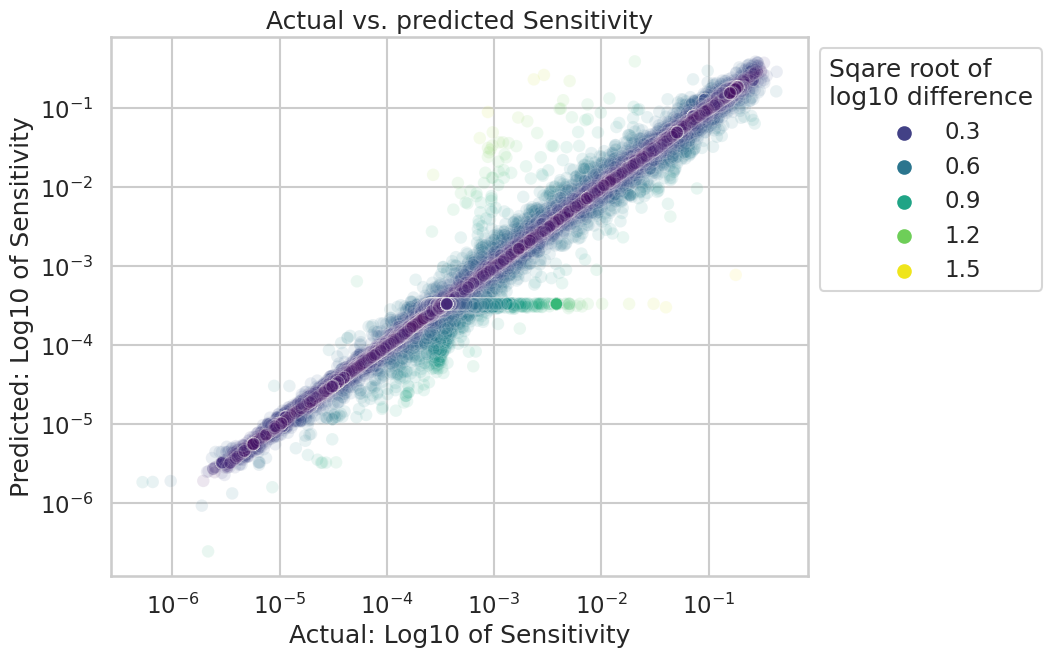

In [150]:

fig = plt.figure(figsize=(9, 7))
fig.subplots_adjust(hspace=0.325)

filt = data['sample_name'] == INPUT_SPECIES
g = sns.scatterplot(data[filt], 
                x='predicted_' + target_circ_func, 
                y=target_circ_func, 
                alpha=0.1,
                hue=np.sqrt(np.abs(np.log10(data[filt]['predicted_' + target_circ_func]) - np.log10(data[filt][target_circ_func]))),
                palette='viridis')
g.legend_.set_title('Sqare root of\nlog10 difference')
plt.title(f'Actual vs. predicted ' + prettify_keys_for_label(target_circ_func).split(' with')[0])
plt.xlabel('Actual: Log10 of ' + prettify_keys_for_label(target_circ_func).split(' with')[0])
plt.ylabel('Predicted: Log10 of ' + prettify_keys_for_label(target_circ_func).split(' with')[0])

sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.xscale('log')
plt.yscale('log')

fig.savefig('Train_data_accuracy.svg')

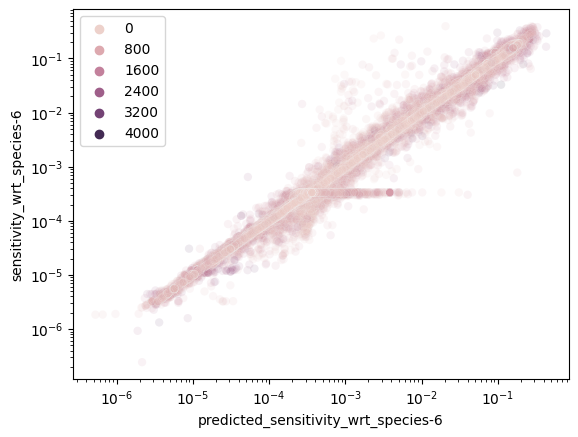

In [22]:
filt = data['sample_name'] == INPUT_SPECIES
sns.scatterplot(data[filt], 
                x='predicted_' + target_circ_func, 
                y=target_circ_func, 
                alpha=0.1,
                hue=np.power(data[filt][get_true_interaction_cols(data, 'energies', remove_symmetrical=True)].sum(axis=1), 2),
                palette='viridis')
plt.xscale('log')
plt.yscale('log')

### Barplots

In [98]:
k = 'energies'
data['predicted_diffs_' + target_circ_func] = data.groupby(by=
    ['circuit_name', 'sample_name'])['predicted_' + target_circ_func].transform(lambda x: x - x.iloc[0]).to_numpy()
data['predicted_ratios_' + target_circ_func] = data.groupby(by=
    ['circuit_name', 'sample_name'])['predicted_' + target_circ_func].transform(lambda x: x / x.iloc[0] if x.iloc[0] > 0 else 1e10).to_numpy()


In [92]:
data['actual_diffs_' + target_circ_func] = data.groupby(by=
    ['circuit_name', 'sample_name'])[target_circ_func].transform(lambda x: x - x.iloc[0]).to_numpy()
data['actual_ratios_' + target_circ_func] = data.groupby(by=
    ['circuit_name', 'sample_name'])[target_circ_func].transform(lambda x: x / x.iloc[0] if x.iloc[0] > 0 else np.ones_like(x) * np.inf).to_numpy()


In [153]:
# debugging: simulated ratio vs. calculated ratio

# plt.figure(figsize=(14, 6))
# ax = plt.subplot(1,2,1)
# sns.barplot(data[filt], x='mutation_num', y=target_circ_func + '_ratio_from_mutation_to_base', palette='viridis')
# ax = plt.subplot(1,2,2)
# sns.barplot(data[filt], x='mutation_num', y='actual_ratios_' + target_circ_func, palette='viridis')

In [129]:

value_name = 'Sensitivity ratio (from mutation to reference)'
df = data[filt].melt(id_vars='mutation_num', value_vars=[target_circ_func + '_ratio_from_mutation_to_base', 'predicted_ratios_' + target_circ_func], var_name='Label', value_name=value_name)
df['Label'] = df['Label'].str.replace(target_circ_func + '_ratio_from_mutation_to_base', 'Actual')
df['Label'] = df['Label'].str.replace('predicted_ratios_' + target_circ_func, 'Predicted')


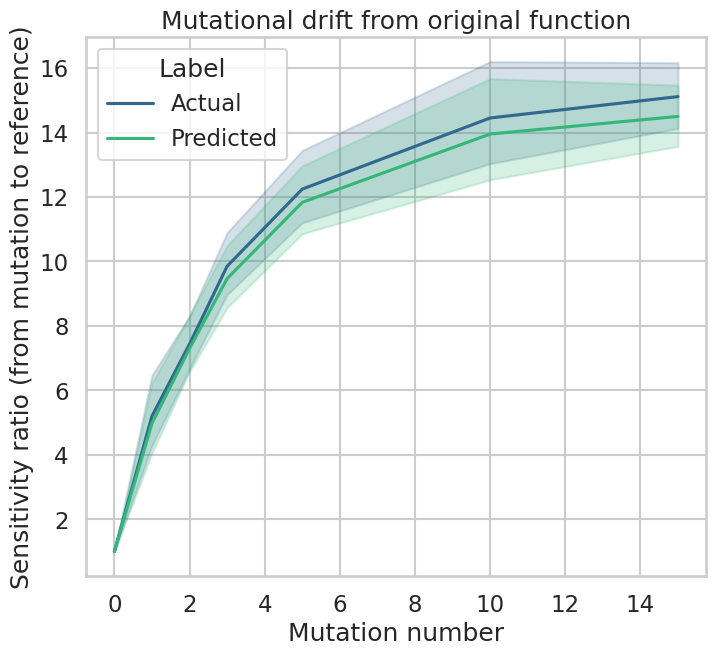

In [145]:
# from matplotlib.patches import FancyBboxPatch

fig = plt.figure(figsize=(8, 7))
sns.lineplot(df, x='mutation_num', y=value_name, hue='Label', palette='viridis')
plt.xlabel(prettify_keys_for_label('mutation_num'))
plt.title('Mutational drift from original function')

fig.savefig('mutational_drift.svg')
# new_patches = []
# for patch in reversed(ax.patches):
#     # bb = patch.get_path().get_extents()
#     bb = patch.get_bbox()
#     color=patch.get_facecolor()
#     p_bbox = FancyBboxPatch((bb.xmin, bb.ymin),
#                         abs(bb.width), abs(bb.height),
#                         boxstyle="round,pad=-0.0040,rounding_size=0.05",
#                         ec="none", fc=color,
#                         mutation_aspect=4
#                         )
#     patch.remove()
#     new_patches.append(p_bbox)
# for patch in new_patches:
#     ax.add_patch(patch)

### Test data

In [147]:
tdata = pd.read_csv(fn_test_data)
len(tdata)

,circuit_name,mutation_name,mutation_num,mutation_type,mutation_positions,path_to_template_circuit,index,name,interacting,self_interacting,...,initial_steady_states,max_amount,min_amount,overshoot,RMSE,steady_states,response_time_wrt_species-6,precision_wrt_species-6,sensitivity_wrt_species-6,sample_name
0,toy_mRNA_circuit_0,ref_circuit,0,[],[],data/ensemble_mutation_effect_analysis/2023_10...,0.0,toy_mRNA_circuit_0,[],[[2 2]],...,199.741350,400.000000,199.741350,0.470428,0.0,399.529570,0.0,1.002355,1.000000,RNA_0
1,toy_mRNA_circuit_0,ref_circuit,0,[],[],data/ensemble_mutation_effect_analysis/2023_10...,0.0,toy_mRNA_circuit_0,[],[[2 2]],...,199.741350,199.741350,199.674550,0.000000,0.0,199.674550,inf,2997.750500,0.000334,RNA_1
2,toy_mRNA_circuit_0,ref_circuit,0,[],[],data/ensemble_mutation_effect_analysis/2023_10...,0.0,toy_mRNA_circuit_0,[],[[2 2]],...,5.773583,5.773583,5.771651,0.000000,0.0,5.771651,inf,2996.652300,0.000334,RNA_2
3,toy_mRNA_circuit_0,RNA_0_m1-0,1,[4],[14],data/ensemble_mutation_effect_analysis/2023_10...,0.0,toy_mRNA_circuit_0,[],[[2 2]],...,199.741350,400.000000,199.741350,0.470428,0.0,399.529570,0.0,1.002355,1.000000,RNA_0
4,toy_mRNA_circuit_0,RNA_0_m1-0,1,[4],[14],data/ensemble_mutation_effect_analysis/2023_10...,0.0,toy_mRNA_circuit_0,[],[[2 2]],...,199.741350,199.741350,199.674550,0.000000,0.0,199.674550,inf,2997.750500,0.000334,RNA_1


In [149]:
tdata['predicted_' + target_circ_func] = np.power(
    10,
    model.apply(p, rng, xscaler.fit_transform(tdata[get_true_interaction_cols(
        tdata, 'energies', remove_symmetrical=True)].values), call_kwargs={'inference': True, 'logging': False})
    )

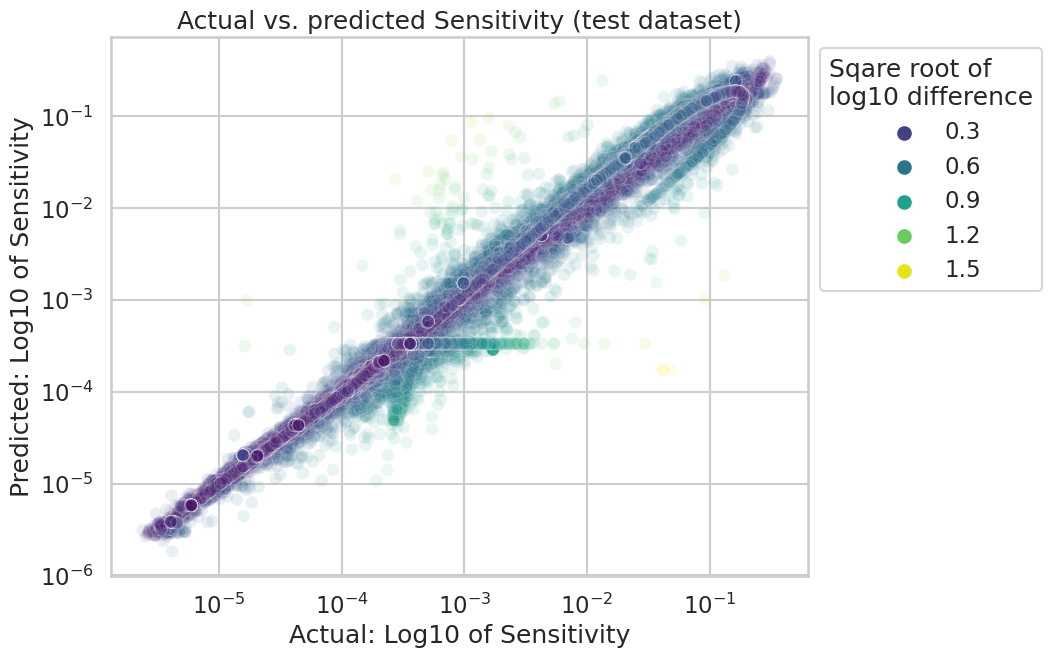

In [152]:
fig = plt.figure(figsize=(9, 7))
fig.subplots_adjust(hspace=0.325)

filt = tdata['sample_name'] == INPUT_SPECIES
g = sns.scatterplot(tdata[filt], 
                x='predicted_' + target_circ_func, 
                y=target_circ_func, 
                alpha=0.1,
                hue=np.sqrt(np.abs(np.log10(tdata[filt]['predicted_' + target_circ_func]) - np.log10(tdata[filt][target_circ_func]))),
                palette='viridis')
g.legend_.set_title('Sqare root of\nlog10 difference')
plt.title(f'Actual vs. predicted ' + prettify_keys_for_label(target_circ_func).split(' with')[0] + ' (test dataset)')
plt.xlabel('Actual: Log10 of ' + prettify_keys_for_label(target_circ_func).split(' with')[0])
plt.ylabel('Predicted: Log10 of ' + prettify_keys_for_label(target_circ_func).split(' with')[0])

sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.xscale('log')
plt.yscale('log')

fig.savefig('Test_data_accuracy.svg')